In [1]:
# POPULATION ANALYSIS - naive population analysis, regulation!

# import list
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import main_funcs as mfun
import utils_funcs as utils
import plot_funcs as pfun
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from itertools import compress
import seaborn as sns
from sklearn import preprocessing

#parameters
fRate = 1000/30.0
pre_frames    = 2000.0# in ms
pre_frames    = int(np.ceil(pre_frames/fRate))
post_frames   = 6000.0 # in ms
post_frames   = int(np.ceil(post_frames/fRate))
analysis_time = 1500.0 # in ms
analysis_time = int(np.ceil(analysis_time/fRate))
simulationDur_ms = 350.0 # in ms
simulationDur = int(np.ceil(simulationDur_ms/fRate))

#paths

savefigpath  = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\figs\\'
analysispath = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\'

responsiveSensory, responsiveNoSensory = mfun.selectInterestedcells ( 'CTAP',  'Naive', responsive = True, plotValues = False, pupil = False )

# load data
infoPath = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\infoForAnalysis-readyForPlotting.pkl'
dff_traceBoth, dff_traceVis, dff_traceOpto, dff_meanBoth1sec, dff_meanVis1sec, dff_meanOpto1sec  = pd.read_pickle(infoPath) 

#infoPath = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\infoForAnalysis-readyForPlotting_normalised.pkl'
#dff_traceBoth_normalised, dff_traceVis_normalised, dff_traceOpto_normalised = pd.read_pickle(infoPath) 

print('Sensory responsive cell number:'+ str(np.sum(responsiveSensory)))



Env: clapfcstimulation
Sensory responsive cell number:4717


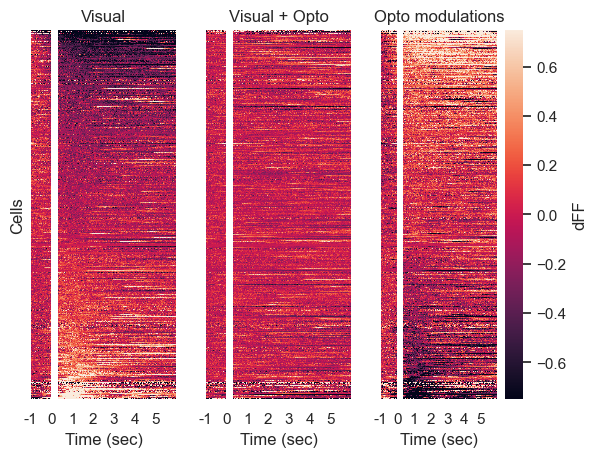

In [2]:
# Plot the heat map for all responsive cells

yminValue = -0.75
ymaxValue = 0.75


# HEAT PLOT FOR RESPONSIVE SENSORY CELLS
index = responsiveSensory
sortedInd = np.array(dff_meanVis1sec[index]).argsort()

plt.subplot(1,3,1)
plot_data = dff_traceVis[index]
plot_data = plot_data[sortedInd]
x_labels = np.linspace(-2, 6, plot_data.shape[1], dtype = int)
step = 30
xticks = np.arange(0, len(x_labels), step)
xticklabels = x_labels[::step]
ax = sns.heatmap(plot_data, vmin = yminValue, vmax = ymaxValue, cbar = False, yticklabels = False)
plt.xticks (ticks = xticks, labels= xticklabels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plot_dataV = plot_data
plt.xlim(30,240)
plt.xlabel('Time (sec)')
plt.ylabel('Cells')
plt.title('Visual')

plt.subplot(1,3,2)
plot_data = dff_traceBoth[index]
plot_data = plot_data[sortedInd]
ax = sns.heatmap(plot_data, vmin = yminValue, vmax = ymaxValue, cbar = False, yticklabels = False)
plt.xticks (ticks = xticks, labels= xticklabels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plot_dataB = plot_data
plt.xlim(30,240)
plt.xlabel('Time (sec)')
plt.title('Visual + Opto')

plt.subplot(1,3,3)
#sortedInd = np.array(dff_meanBoth1sec[index]).argsort()
plot_data = plot_dataB - plot_dataV

ax = sns.heatmap(plot_data, vmin = yminValue, vmax = ymaxValue, cbar = True, yticklabels = False,
                  cbar_kws={'label': 'dFF'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.xticks (ticks = xticks, labels= xticklabels)
plot_diff = plot_data
plt.xlim(30,240)
plt.xlabel('Time (sec)')
plt.title('Opto modulations')

pfun.save_figure( 'Figure2_Heat-map_SensoryResponsive-AllComparison',savefigpath)

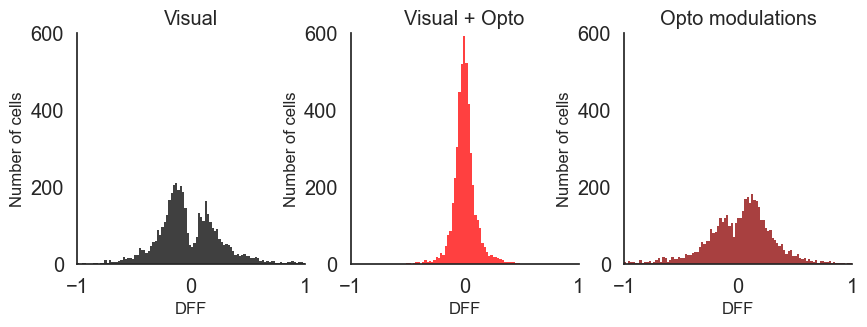

In [3]:
# Plot the histograms

plot_dataVmean = np.nanmean(plot_dataV [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
plot_dataBmean = np.nanmean(plot_dataB [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
pfun.set_figure()
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3))

plt.subplot(1,3,1)
sns.histplot(plot_dataVmean, binwidth = 0.02, color = 'black')
plt.title('Visual')
plt.xlim(-1, 1)
plt.ylim(0, 600)
plt.ylabel('Number of cells')
plt.xlabel('DFF')
plt.subplot(1,3,2)
sns.histplot(plot_dataBmean, binwidth = 0.02, color = 'red',)
plt.title('Visual + Opto')
plt.xlim(-1, 1)
plt.ylim(0, 600)
plt.ylabel('Number of cells')
plt.xlabel('DFF')
plt.subplot(1,3,3)
sns.histplot(plot_dataBmean-plot_dataVmean, binwidth = 0.02, color = 'darkred')
plt.title('Opto modulations')
plt.xlim(-1, 1)
plt.ylim(0, 600)
plt.ylabel('Number of cells')
plt.xlabel('DFF')

pfun.save_figure( 'Figure2_Histogram_SensoryResponsive-AllComparison',savefigpath)

2.220007e-317


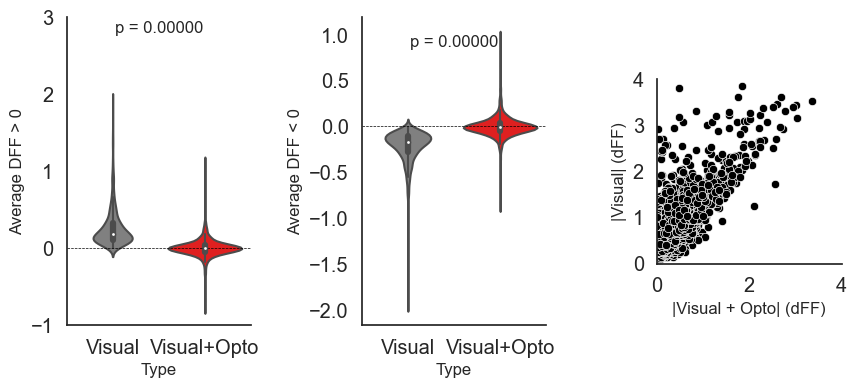

In [13]:
# Correlation plot for magnitude in change
# If it was a higher magnitude of response, is it larger change? 

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 4))
plt.subplots_adjust( hspace = 0.8, wspace = 0.6)
colors = ['grey', 'red']
pfun.set_figure()

plot_dataVmean = np.nanmean(plot_dataV [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
plot_dataBmean = np.nanmean(plot_dataB [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)

plt.subplot(1,3,1)
index = np.where((2>plot_dataVmean) &(plot_dataVmean>0))[0]
plot_data = pd.DataFrame( {'Mean DFF' :np.concatenate((plot_dataVmean[index], plot_dataBmean[index])), 
                              'Type':  np.concatenate((np.repeat('Visual', len(plot_dataVmean[index])), np.repeat('Visual+Opto', len(plot_dataBmean[index]))))})
sns.violinplot(x = 'Type', y = 'Mean DFF', data = plot_data, palette=colors,  showfliers = False)
plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth = 0.5)
plt.annotate('p = {:.5f}'.format(stats.ttest_ind(plot_dataVmean[index], plot_dataBmean[index])[1], 3), xy=(0.5, 2.95), xytext=(0, 0), textcoords='offset points', 
             ha = 'center', va = 'top', fontsize=12)
print(stats.ttest_ind(plot_dataVmean[index], plot_dataBmean[index])[1])
plt.ylim(-1,3)
plt.ylabel('Average DFF > 0')

plt.subplot(1,3,2)
index = np.where((0>plot_dataVmean) &(plot_dataVmean>-2))[0]
plot_data= pd.DataFrame( {'Mean DFF' :np.concatenate((plot_dataVmean[index], plot_dataBmean[index])), 
                              'Type':  np.concatenate((np.repeat('Visual', len(plot_dataVmean[index])), np.repeat('Visual+Opto', len(plot_dataBmean[index]))))})

sns.violinplot(x = 'Type', y = 'Mean DFF', data = plot_data, palette=colors, showfliers = False)
plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth = 0.5)
plt.annotate('p = {:.5f}'.format(stats.ttest_ind(plot_dataVmean[index], plot_dataBmean[index])[1], 3), xy=(0.5, 1), xytext=(0, 0), textcoords='offset points', 
             ha = 'center', va = 'top', fontsize=12)
plt.ylabel('Average DFF < 0')


plt.subplot(1,3,3)

plot_dataVmean = np.nanmax(plot_dataV [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
plot_dataBmean = np.nanmax(plot_dataB [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
plot_diff = np.abs(plot_dataBmean - plot_dataVmean)
plot_dataVmean = np.nanmax(np.abs(plot_dataV [:, pre_frames:(pre_frames + simulationDur + analysis_time)]), axis = 1)
plot_data = pd.DataFrame( {'|Visual| (dFF)' :plot_dataVmean, 
                           '|Visual + Opto| (dFF)':  plot_diff})
sns.scatterplot (y = '|Visual| (dFF)', x = '|Visual + Opto| (dFF)', data = plot_data, color='black')
plt.ylim(0,4)
plt.xlim(0,4)
axs[2].set_aspect('equal')


pfun.save_figure( 'Figure2_Violin_SensoryResponsive-AllComparison',savefigpath)

In [ ]:
# # If it was a higher magnitude of response, is it larger change? 

# fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize=(8.27/4, 11.69))
# plt.subplots_adjust(bottom = 0.5, top =1.5, hspace = 0.5, wspace = 0.4)
# colors = ['grey', 'red']
# pfun.set_figure()



# plt.subplot(3,1,1)
# sns.scatterplot (y = 'Visual', x = 'Visual + Both', data = plot_data, palette=colors)
# plt.ylim(0,30)
# plt.xlim(-15,15)
# axs[0].set_aspect('equal')

# plt.subplot(3,1,2)
# sns.scatterplot (y = 'Visual', x = 'Visual + Both', data = plot_data, palette=colors)
# plt.ylim(0,8)
# plt.xlim(-4,4)
# axs[1].set_aspect('equal')

# plt.subplot(3,1,3)
# plot_dataVmean = np.nanmax(plot_dataV [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
# plot_dataBmean = np.nanmax(plot_dataB [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
# plot_diff = np.abs(plot_dataBmean - plot_dataVmean)
# plot_dataVmean = np.nanmax(np.abs(plot_dataV [:, pre_frames:(pre_frames + simulationDur + analysis_time)]), axis = 1)
# plot_data = pd.DataFrame( {'Visual' :plot_dataVmean, 
#                            'Visual + Both':  plot_diff})
# sns.scatterplot (y = 'Visual', x = 'Visual + Both', data = plot_data, palette=colors)
# plt.ylim(0,4)
# plt.xlim(0,4)
# axs[3].set_aspect('equal')


# pfun.save_figure( 'Figure2_Correlation_SensoryResponsive-AllComparison',savefigpath)